In [ ]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [ ]:
import sys

if ".." not in sys.path:
    sys.path.append("..")

In [ ]:
from datasets.ImageNet.ImageNetDataset import ImageNet

In [ ]:
root = "/datashare/ImageNet/ILSVRC2012"
meta_path = (
    "/home/soroush1/projects/def-kohitij/soroush1/pretrain-imagenet/data/ImageNet"
)


ds = ImageNet(root=root, dst_meta_path=meta_path)

In [ ]:
ds.wnid_to_idx

In [ ]:
!ls /datashare/ImageNet/tiny-imagenet-200/

In [ ]:
!cat /datashare/ImageNet/tiny-imagenet-200/words.txt

In [ ]:
!ls /datashare/ImageNet/tiny-imagenet-200/val/images

In [188]:
!cat /datashare/ImageNet/tiny-imagenet-200/val/val_annotations.txt

val_0.JPEG	n03444034	0	32	44	62
val_1.JPEG	n04067472	52	55	57	59
val_2.JPEG	n04070727	4	0	60	55
val_3.JPEG	n02808440	3	3	63	63
val_4.JPEG	n02808440	9	27	63	48
val_5.JPEG	n04399382	7	0	59	63
val_6.JPEG	n04179913	0	0	63	56
val_7.JPEG	n02823428	5	0	57	63
val_8.JPEG	n04146614	0	31	60	60
val_9.JPEG	n02226429	0	3	63	57
val_10.JPEG	n04371430	37	38	44	45
val_11.JPEG	n07753592	0	1	63	47
val_12.JPEG	n02226429	5	12	57	53
val_13.JPEG	n03770439	21	33	36	43
val_14.JPEG	n02056570	0	19	63	47
val_15.JPEG	n02906734	1	0	48	22
val_16.JPEG	n02125311	7	16	60	55
val_17.JPEG	n04486054	0	9	63	63
val_18.JPEG	n04285008	0	11	63	57
val_19.JPEG	n03763968	18	6	53	63
val_20.JPEG	n03814639	16	22	33	36
val_21.JPEG	n03837869	40	7	51	63
val_22.JPEG	n01983481	27	28	61	63
val_23.JPEG	n01629819	0	1	52	48
val_24.JPEG	n04532670	0	19	63	31
val_25.JPEG	n04074963	40	0	58	63
val_26.JPEG	n04540053	36	0	44	6
val_27.JPEG	n04371430	2	5	63	54
val_28.JPEG	n02906734	37	24	52	32
val_29.JPEG	n02094433	10	1	58	63
val_30.JPEG	n03796401	0	15

In [ ]:
TINY_IMAGENET_PATH = os.path.join("/datashare/ImageNet/tiny-imagenet-200/")

In [186]:
from torchvision.datasets.folder import ImageFolder
from torchvision.datasets.utils import verify_str_arg

import torch

import matplotlib.pyplot as plt
import shutil

from typing import Any, Dict, Tuple, List

In [201]:
class TinyImageNet(ImageFolder):
    def __init__(
        self,
        root: str,
        split: str = "train",
        dst_meta_path: str = os.path.join(os.getcwd(), "data", "ImageNetTiny"),
        **kwargs: Any,
    ):
        root = self.root = os.path.expanduser(root)

        self.dst_meta_path = dst_meta_path
        os.makedirs(dst_meta_path, exist_ok=True)

        self.split = verify_str_arg(split, "split", ("train", "val"))
        self.parse_archives()
        wnid_to_classes = self.load_meta_file()[0]

        self.split_folder = os.path.join(root, split)
        if split == "val":
            self.split_folder = os.path.join(dst_meta_path, "val")

        super().__init__(
            self.split_folder,
            **kwargs,
        )

        self.root = root
        self.wnids = self.classes
        self.wnid_to_idx = self.class_to_idx
        self.wnid_to_classes = wnid_to_classes
        self.classes = [wnid_to_classes[wnid] for wnid in self.wnids]
        self.class_to_idx = {
            cls: idx for idx, clss in enumerate(self.classes) for cls in clss
        }

    def parse_archives(self) -> None:
        if not os.path.exists(os.path.join(self.dst_meta_path, META_FILE)):
            print(f"{os.path.join(self.dst_meta_path, META_FILE)} doesn't exist.")
            self.__parse_devkit_archive(dst_meta_path=self.dst_meta_path)

    def load_meta_file(self) -> Tuple[Dict[str, str], List[str]]:
        file = os.path.join(self.dst_meta_path, META_FILE)
        return torch.load(file, weights_only=True)

    def __parse_devkit_archive(self, dst_meta_path: str):

        import scipy.io as sio

        def parse_meta_txt(
            devkit_root: str,
        ) -> Tuple[Dict[int, str], Dict[str, Tuple[str, ...]]]:
            with open(os.path.join(root, "words.txt"), "r") as f:
                wnid_to_classes = {}
                for x in f:
                    code, description = x.strip().split("\t", 1)
                    wnid_to_classes[code] = tuple(description.split(", "))

            with open(os.path.join(root, "wnids.txt"), "r") as f:
                wnids = [x.strip() for x in f]

            # Map wnids to integer labels
            idx_to_wnid = {i: wnid for i, wnid in enumerate(wnids)}

            return idx_to_wnid, wnid_to_classes

        def parse_val_groundtruth_txt(devkit_root: str) -> List[int]:
            file = os.path.join(devkit_root, "val", "val_annotations.txt")
            dst_val_images_path = os.path.join(self.dst_meta_path, "val")
            os.makedirs(dst_val_images_path, exist_ok=True)

            val_wnids = []
            with open(os.path.join(root, "val", "val_annotations.txt"), "r") as f:
                for x in f:
                    image_name, wnid = x.strip().split("\t")[:2]

                    os.makedirs(os.path.join(dst_val_images_path, wnid), exist_ok=True)

                    if not os.path.exists(
                        os.path.join(dst_val_images_path, wnid, image_name)
                    ):
                        shutil.copy(
                            os.path.join(val_path, "images", image_name),
                            os.path.join(dst_val_images_path, wnid, image_name),
                        )

                    val_wnids.append(wnid)
            return val_wnids

        devkit_root = os.path.join(self.root)
        idx_to_wnid, wnid_to_classes = parse_meta_txt(devkit_root)
        val_wnids = parse_val_groundtruth_txt(devkit_root)
        torch.save((wnid_to_classes, val_wnids), os.path.join(dst_meta_path, META_FILE))

In [202]:
root = TINY_IMAGENET_PATH
split = "val"
META_FILE = "meta.bin"

tiny_ds = TinyImageNet(root=root, split=split)

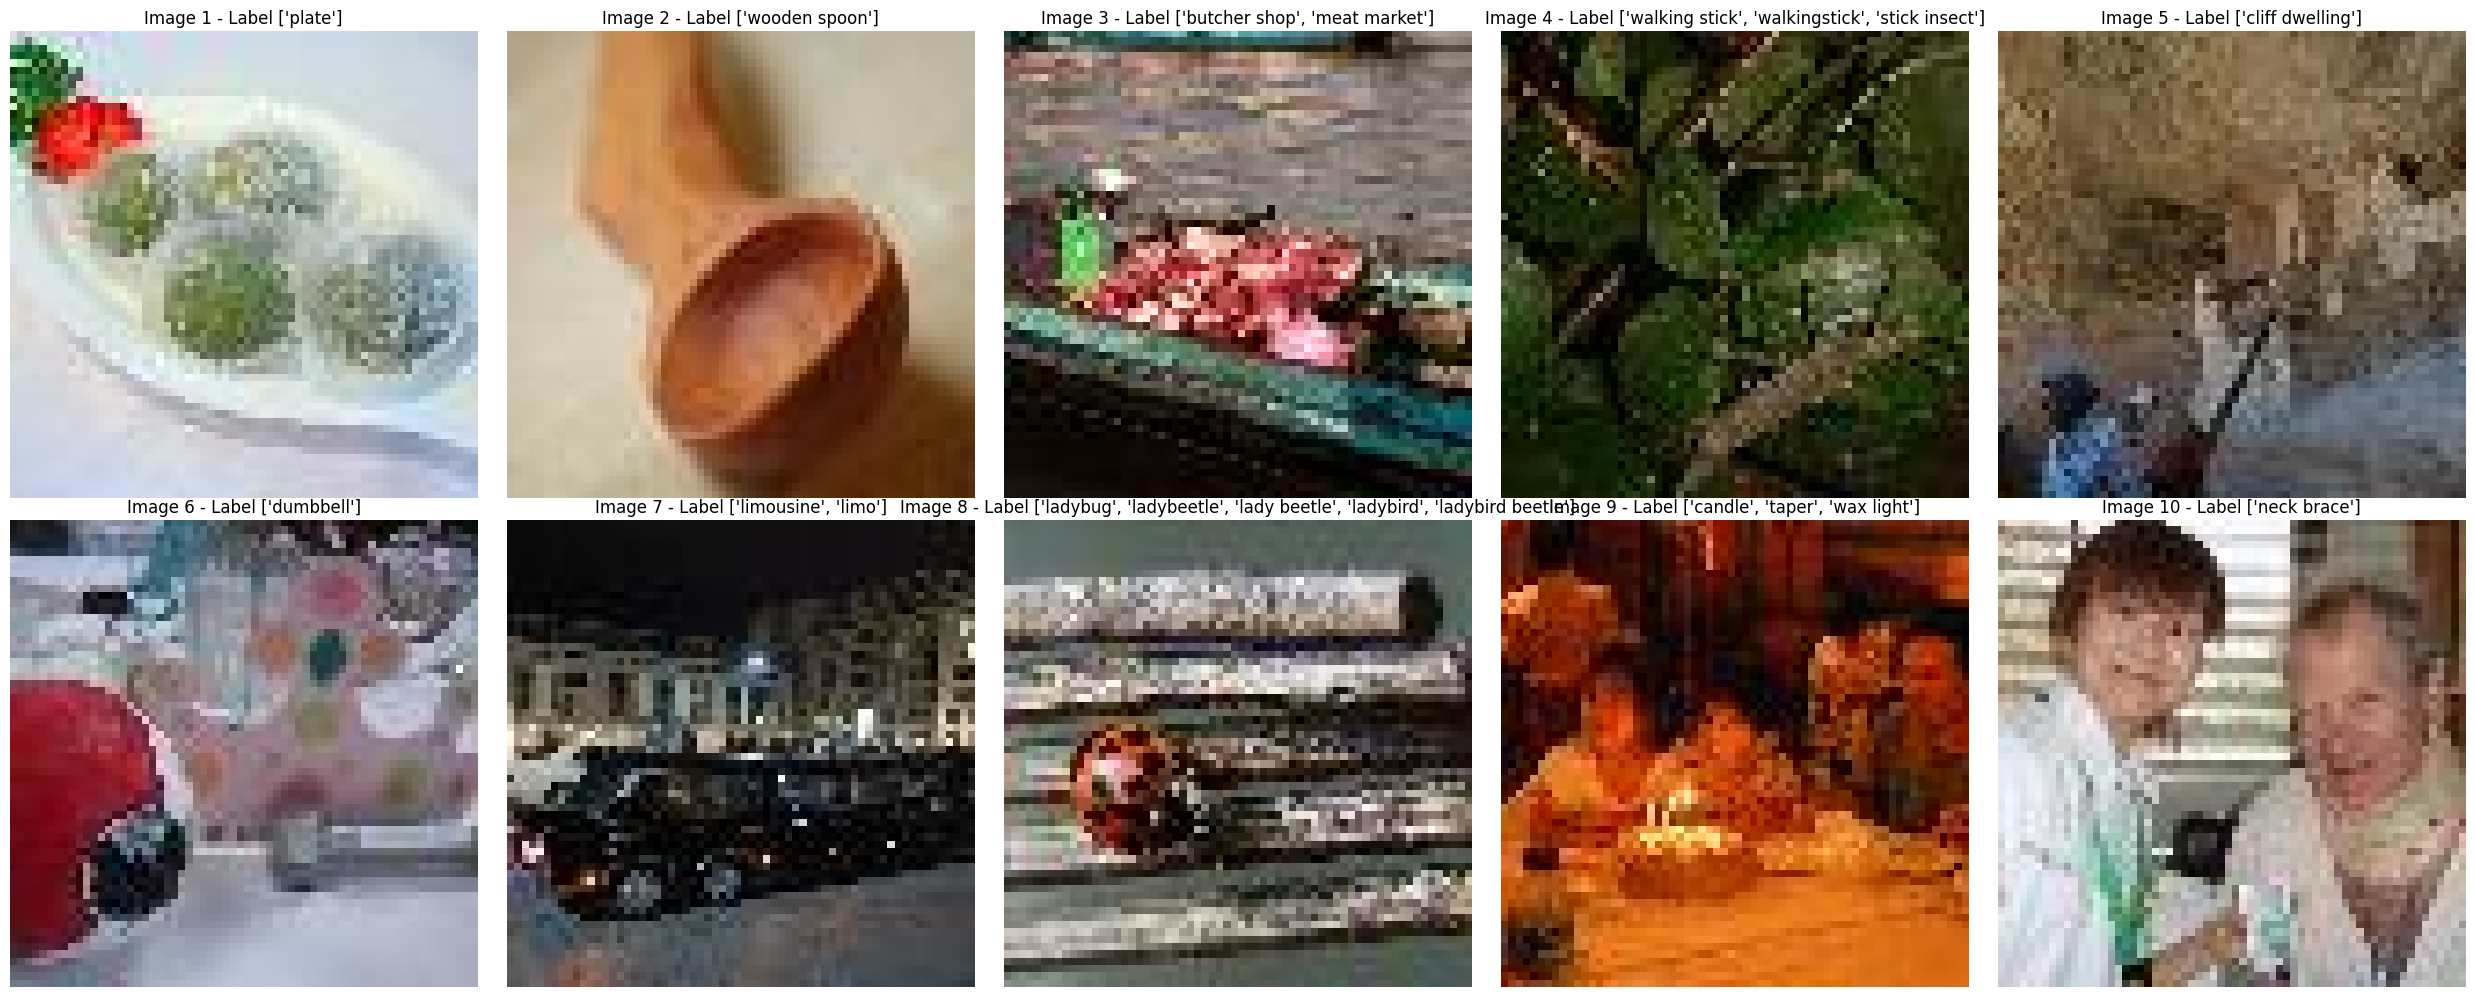

In [204]:
def idx_to_class(dataset, label):
    return [key for key, value in dataset.class_to_idx.items() if value == label]


random_idx = np.random.randint(0, len(tiny_ds), 10)

plt.figure(figsize=(25, 10))

for i, idx in enumerate(random_idx):

    img, label = tiny_ds[idx]

    plt.subplot(2, 5, i + 1)  # Adjust subplot layout as needed
    plt.imshow(img)

    plt.title(f"Image {i+1} - Label {idx_to_class(tiny_ds, label)}")
    plt.axis("off")

plt.tight_layout()
plt.show()